# 2 - Análise exploratória de dados

Nessa fase, analisaremos a base de treino como um todo, verificando o balanceamento entre as classes e focando, principalmente, na coluna *`tweet_text`*;

In [ ]:
# caminho para instalação do pacote mltoolkit, com metricas e gráficos personalizados
# !pip install git+ssh://git@github.com/flimao/mltoolkit

In [6]:
import pandas as pd
import numpy as np
from matplotlib import rcParams, rcParamsDefault, pyplot as plt
import seaborn as sns
from mltoolkit import metrics, plots

rcParams.update(rcParamsDefault)
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

## Importação dos dados

Primeiramente, importamos os dados e aplicamos as transformações utilizadas na fase anterior:

In [3]:
# não tocaremos no conjunto de submissão

tweets_raw = pd.read_csv(
    r'../data/Train3Classes.csv',
)

In [4]:
# trocar tipos para acelerar o processamento (menos espaço em memória)
# e ativar possíveis otimizações internas ao pandas para certos tipos
def mudar_tipos(df):
    df = df.copy()

    df['id'] = df['id'].astype('string')
    df['tweet_date'] = pd.to_datetime(df['tweet_date'])
    df['sentiment'] = df['sentiment'].astype('category')

    return df

def remover_duplicatas(df):
    df = df.copy()

    df = df.drop_duplicates(subset = 'id')

    return df

# o índice é o id, visto que não há repetidos
# vantagem: o índice é removido automaticamente quando separamos em base de treino e teste.
def setar_index(df):
    df = df.copy()

    df = df.set_index('id')

    return df

tweets = (tweets_raw
    .pipe(mudar_tipos)
    .pipe(remover_duplicatas)
    .pipe(setar_index)
)

## Exploração

Vamos conhecer a base mais de perto.

### Balanceamento

Vamos checar a quantidade relativa de *tweets* negativos, positivos e neutros:

In [5]:
tweets.sentiment.value_counts()

0    31696
1    31677
2    31614
Name: sentiment, dtype: int64

O conjunto total parece ser quase exatamente balanceado.

### Relação do sentimento com a data do *tweet*

Vamos ver se o tom do *tweet* (negativo, positivo ou neutro) muda ao longo do tempo:

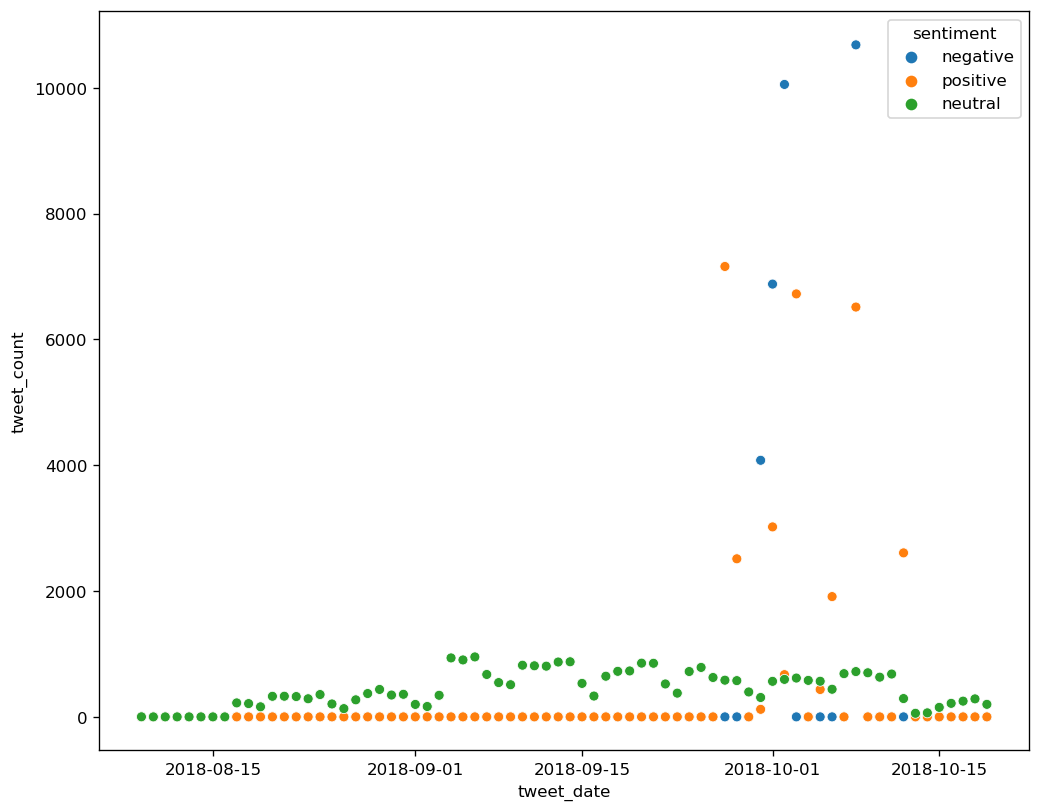

In [93]:
tweets_days = tweets.groupby(by = ['sentiment', pd.Grouper(
    key = 'tweet_date',
    freq = 'D'
)])['tweet_text'].count().reset_index()

tweets_days = tweets_days.rename(columns = {'tweet_text': 'tweet_count'})
#tweets_days.loc[tweets_days.tweet_count == 0, 'tweet_count'] = pd.NA

sns.scatterplot(
    data = tweets_days,
    x = 'tweet_date',
    y = 'tweet_count',
    hue = tweets_days['sentiment'].map({
        0: 'negative',
        1: 'positive',
        2: 'neutral'
    }),
)
plt.show()

In [86]:
# vamos calcular a proporção de tweets de cada sentimento em cada dia

tweets_wide = tweets_days.pivot(
    index = 'tweet_date',
    values = 'tweet_count',
    columns = 'sentiment',
)

tweets_wide_prop = tweets_wide.divide(tweets_wide.sum(axis = 1), axis = 0).dropna()

tweets_wide_prop

tweets_days_prop = tweets_wide_prop.reset_index().melt(
    id_vars = 'tweet_date',
    var_name = 'sentiment',
    value_name = 'tweet_prop',
).set_index(['tweet_date', 'sentiment'])

tweets_days = tweets_days.set_index(['tweet_date', 'sentiment'])

tweets_days_prop

tweets_days['tweet_proportion'] = tweets_days_prop['tweet_prop']
tweets_days = tweets_days.reset_index()

In [89]:
# período em que parece haver grande número de tweets positivos e negativos

tweets_days[
    ('2018-09-26' <= tweets_days.tweet_date) & 
    (tweets_days.tweet_date <= '2018-10-13') &
    (tweets_days.sentiment != 2) & 
    (tweets_days.tweet_count > 0)
]

,tweet_date,sentiment,tweet_count,tweet_proportion
52,2018-09-30 00:00:00+00:00,0,4079,0.905037
53,2018-10-01 00:00:00+00:00,0,6880,0.657430
54,2018-10-02 00:00:00+00:00,0,10054,0.888084
60,2018-10-08 00:00:00+00:00,0,10683,0.596216
121,2018-09-27 00:00:00+00:00,1,7160,0.924706
122,2018-09-28 00:00:00+00:00,1,2513,0.813532
124,2018-09-30 00:00:00+00:00,1,120,0.026625
125,2018-10-01 00:00:00+00:00,1,3020,0.288581
126,2018-10-02 00:00:00+00:00,1,671,0.059270
127,2018-10-03 00:00:00+00:00,1,6724,0.915952


Em conclusão:

* Os *tweets* começam em 9 de agosto, mas só há nessa data um único *tweet*. Os *tweets* começam de fato em número mais expressivo em 17 de agosto.

Além disso, parece haver uma distribuição peculiar dos *tweets* ao longo do tempo:

* *Tweets* de tom neutro parecem se manter constantes (descontando um padrão de sazonalidade) ao longo do tempo;

* *Tweets* negativos e positivos se concentram em um período de duas semanas, entre o fim de setembro e meados de outubro, em grande quantidade.
    
    * *Tweets* de tom negativo só aparecem em 4 dias no período estudado. Nos dias em que aparecem, a proporção de *tweets* negativos (em relação ao total) é de pelo menos 60%;

    * Fora desse período, a maioria esmagadora dos *tweets* são de tom neutro;

    * Esse período é marcado por uma quantidade maior de *tweets* (os de tom neutro se mantém +- constantes, os de tom positivo e negativo aumentam muito).


In [95]:
# exemplos de tweets com sentimento negativo

with pd.option_context('display.max_colwidth', 500):
    display(tweets[tweets.sentiment == 0].sample(10)['tweet_text'])

id
1046270726314045440                                                                                                                                              peguei :(( https://t.co/3eTX2wL1YC
1049295934759288832      @marih_molero Sim :( só mostra que a gente vive na bolha mesmo. Pelo menos qm corre com a gente eh minimamente preocupado com os direitos humanos. (No caso, n td mundo ne
1046935284741525506                                                                                                                                                  @JWWPSDS :( era pra marcar oq?
1049311200859893760                                                                                                                    fui embora mais cedo da escola pq tava me sentindo mal la :(
1049285386994929665                                                                                                                                                     @igorpdsantos eita cara! :(
10467954253097082

Um evento de grande monta que ocorreu no período de aparente maior polarização (maior proporção de *tweets* com sentimento negativo ou positivo, menos *tweets* de tom neutro) foi o 1° turno da eleição para presidente no Brasil. É razoável que a polarização no sentimento da base de *tweets* seja em parte reflexo da alta polarização da campanha eleitoral.

Ressaltamos que, se for esse o caso, o eventual modelo construído será severamente enviesado. As palavras que ele associará a *tweets* negativos, positivos ou neutros serão tomadas por expressões relativas às eleições, por exemplo, `lula`, `haddad`, `pt`, `bolsonaro` etc. Isso prejudicará a generalização do modelo, pois fora do contexto eleitoral não há motivo para crer que essas palavras são inerentemente positivas, negativas ou neutras.